### 観測データ
解析に必要なデータ
- XFFTS data
- encoder (doppler計算できない)
- weather status
- hosei copy
- obs copy


### 解析フロー

- doppler tracking[x]
- Chopper Wheel [o]
- baseline fitting [o]
- Scaling(from standard object?) [x]
- regrid [o]
    - rms [o]
    - distance [o]
- +header [o]
- 3d-fits[o]

In [34]:
!ls /home/amigos/data/position_switching2019/n20190831094711_12CO_2-1_otf_OriKL/
import time
start_time = time.time()

hosei_230.txt  ps_OriKL.obs  weather.csv  xffts.ndf


In [35]:
#radec 変換データ作成
#! python analy_coordinates.py
import sys
sys.path.append("../script/")
import subprocess
import os
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import numba
from astropy.io import fits
import glob
from scipy import interpolate
###以下独自
import n2df
import read_obsfile
import analy_doppler_nanten

In [36]:
analy_dir = "/home/amigos/data/position_switching2019/n20190831094711_12CO_2-1_otf_OriKL/"
analy_dir = "/home/amigos/data/position_switching2019/n20190904073619_12CO_2-1_otf_OriKL/" # hosei parameters= 0
analy_dir = "/home/amigos/data/position_switching2019/n20190905095023_12CO_2-1_otf_OriKL"
subprocess.getoutput(["ls {}".format(analy_dir)]).split("\n")
obspath = glob.glob(analy_dir+"/*obs")
obs = read_obsfile.read(obspath[0])

In [37]:
import log_weather
import numpy
###気象情報の読み込み
weather_data = log_weather.Weather_log(os.path.join(analy_dir, "weather.csv")).read()
print(weather_data)
#気象データの確認
press = numpy.mean(weather_data["press"])
humi = numpy.mean(weather_data["outhumi"])
temp = numpy.mean(weather_data["outtemp"])
lamda = 1300
print(press, humi, temp)

cabin_temp = weather_data["cabin_temp1"]

      timestamp     intemp    outtemp    inhumi   outhumi     winddir  \
0  1.567677e+09  14.817523  16.467085  1.395623  8.417884  268.147779   
1  1.567677e+09  14.909180  16.556446  1.844776  8.472555  268.014015   
2  1.567677e+09  14.625453  16.492540  1.487004  8.999487  268.853837   
3  1.567677e+09  15.186409  15.787022  1.766512  8.900847  268.869596   
4  1.567677e+09  14.570461  16.331364  1.817098  8.081414  268.381161   

     windsp       press      rain  cabin_temp1  cabin_temp2  dome_temp1  \
0  6.524384  570.536064  0.257755    21.365485    31.937307    9.883737   
1  5.837036  570.196707  0.034876    21.838325    31.617535   10.777496   
2  6.389095  570.745107  0.497449    22.261658    32.384257   10.199102   
3  6.522879  570.884245  0.507436    21.674506    31.631646    9.902935   
4  6.779379  570.321818  0.127823    21.684971    31.701229   10.574785   

   dome_temp2  gen_temp1  gen_temp2  scan_num  obs_mode  
0   12.957494   9.944345  13.781421         0       

In [38]:
array_num = 2#1~16IF 

### 分光データの読み出し


In [39]:
%%time
n = n2df.Read(os.path.join(analy_dir, "xffts.ndf"))
array_data = n.read_onearray(array_num)#1IFの分光データ
obs_mode = n.read_obs_mode()#観測モード（ON/OFF/HOT）
scan_num = n.read_scan_num()#スキャンライン（0,1,2,3,4,...）
###array_data, scan_num, obs_mode = n.read_for_otf(1)#3分くらいかかた
timestamp = n.read_timestamp()

100%|██████████| 1468/1468 [00:00<00:00, 992622.65it/s]

CPU times: user 44 ms, sys: 56 ms, total: 100 ms
Wall time: 108 ms


### Doppler tracking

In [40]:
on_x = obs["lambda_on"]
on_y = obs["beta_on"]
off_x = obs["lambda_off"]
off_y = obs["beta_off"]

In [110]:
from numpy import deg2rad
if not os.path.exists(os.path.join(analy_dir, "vobs.npy")):
    vobs = []
    for i in range(len(array_data)):
        if obs_mode[i] == "ON":
            vobs.append(d.calc_vobs(deg2rad(on_x), deg2rad(on_y), timestamp[i]))
        elif obs_mode[i] == "OFF" or obs_mode[i] == "HOT":
            vobs.append(d.calc_vobs(deg2rad(off_x), deg2rad(off_y), timestamp[i]))
    numpy.save(os.path.join(analy_dir, "vobs"), vobs)
else:
    print(" vobs.npy already exists")

 vobs.npy already exists


In [49]:
vobs = numpy.load(os.path.join(analy_dir, "vobs.npy"))

# For debug
if numpy.count_nonzero(vobs>0) == len(vobs):
    print("vobsは全て正")
elif numpy.count_nonzero(vobs<0) == len(vobs):
    print("vobsは全て負")
else:
    print("vobsは正も負もある")

# config
dv = 0.167#km/s
ch = numpy.linspace(0, 32767, 32768)
bch = list(map(int, vobs//dv))#ch数の移動
slide_ch = (vobs/dv) - bch#interpolationによる移動量

dp_data = []
xx_data = []
for i in tqdm(range(len(vobs))):
    f = interpolate.interp1d(ch, array_data[i])
    ch2 = ch+slide_ch[i]
    if slide_ch[i] > 0:
        n = f(ch2[:-1])
    elif slide_ch[i] <0:
        n = f(ch2[1:])
    new_p = n
    xx = ch[:-1] - bch[i]
    yy = new_p
    xx_data.append(xx)
    dp_data.append(yy)
    
xx_data = numpy.array(xx_data)
xx_min = numpy.max(xx_data.T[0])#regridの最小値
xx_max = numpy.min(xx_data.T[-1])#regirdの最大値

new_xx = numpy.arange(xx_min, xx_max+1, 1)
print(new_xx, len(new_xx))
vlen = len(new_xx)

mask_list= []
for i in range(len(xx_data)):
    mask = (xx_data[i] >= xx_min) & (xx_data[i] <= xx_max)
    mask_list.append(mask)
    
new_yy_list = []
for i in tqdm(range(len(xx_data))):
    new_yy_list.append(dp_data[i][mask_list[i]])
    
len(new_xx)
origin_array_data = array_data
array_data = new_yy_list
numpy.shape(array_data)

  3%|▎         | 38/1468 [00:00<00:03, 378.46it/s]

vobsは全て正


 79%|███████▉  | 1163/1468 [00:00<00:00, 11623.80it/s]

[  -45.   -44.   -43. ... 32719. 32720. 32721.] 32767


100%|██████████| 1468/1468 [00:00<00:00, 11546.11it/s]


(1468, 32767)

In [50]:
###index探し
obs_mode = numpy.array(obs_mode)
scan_num = numpy.array(scan_num)

offmask = obs_mode == "OFF"
offindex = numpy.where(offmask == True)

hotmask = obs_mode == "HOT"
hotindex = numpy.where(hotmask == True)

onmask = obs_mode == "ON"
onindex = numpy.where(onmask == True)

max_scannum = numpy.max(scan_num)#Caution! scan num starts from 0, so scan number of 26 indicates 27 times scan

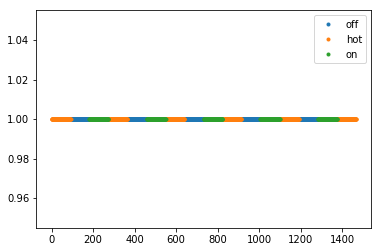

In [51]:
#一応indexの可視化
plt.plot(offindex[0], [1]*len(offindex[0]),"." , label = "off")
plt.plot(hotindex[0], [1]*len(hotindex[0]),"." , label = "hot")
plt.plot(onindex[0], [1]*len(onindex[0]),"." , label = "on")
plt.legend()
plt.show()

[0 0 0 ... 5 5 5]


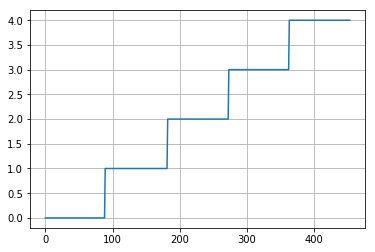

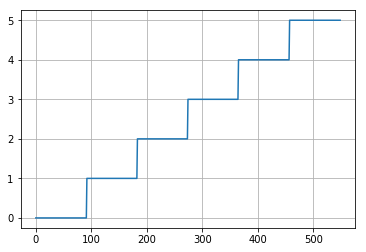

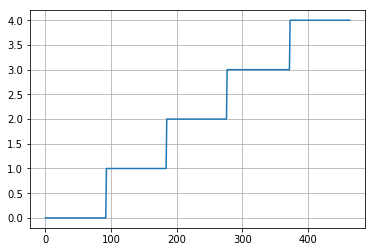

In [52]:
#OFF 点のscan number を取得
scan_num = numpy.array(scan_num)
print(scan_num)
offindex[0]
plt.plot(scan_num[offindex[0]])
plt.grid()
plt.show()

#HOT 点のscan number を取得
scan_num = numpy.array(scan_num)
hotindex[0]
plt.plot(scan_num[hotindex[0]])
plt.grid()
plt.show()

# ON 点のscan number を取得
scan_num = numpy.array(scan_num)
plt.plot(scan_num[onindex[0]])
plt.grid()
plt.show()

### hot/offの積分

In [194]:
#HOT積分
print(numpy.unique(scan_num[hotindex[0]]))#HOT のscan number
hotnum = numpy.unique(scan_num[hotindex[0]])#HOTの数

hotdata = []

for i in tqdm(hotnum):#i = scan number
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], hotindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]
    ###
    mm = index[0][c]#scan numの値でフィルターしたhot
    #print(mm)
    ###積分
    tmp = [array_data[j] for j in mm]
    hotdata.append(sum(tmp)/len(tmp))
    pass

#下は擬似データの質が低いための処理。将来的に削除
#hotdata = numpy.array(hotdata)
#hotdata = hotdata + 5000

100%|██████████| 6/6 [00:00<00:00, 321.09it/s]

[0 1 2 3 4 5]


In [195]:
##OFFの積分
print(numpy.unique(scan_num[offindex[0]]))#HOT のscan number
offnum = numpy.unique(scan_num[offindex[0]])#HOTの数

offdata = []
scan_num = numpy.array(scan_num)

for i in tqdm(offnum):
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], offindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]#scannumとhotで絞ったindex
    mm = index[0][c]#scan numの値でフィルターしたhot
    tmp = [array_data[j] for j in mm]
    offdata.append(sum(tmp)/len(tmp))

100%|██████████| 5/5 [00:00<00:00, 328.43it/s]

[0 1 2 3 4]


In [196]:
##ONの積分
print(numpy.unique(scan_num[onindex[0]]))#HOT のscan number
on_num = numpy.unique(scan_num[onindex[0]])#HOTの数

ondata = []
scan_num = numpy.array(scan_num)

for i in tqdm(on_num):
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], onindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]#scannumとhotで絞ったindex
    mm = index[0][c]#scan numの値でフィルターしたhot
    tmp = [array_data[j] for j in mm]
    ondata.append(sum(tmp)/len(tmp))

100%|██████████| 5/5 [00:00<00:00, 313.07it/s]

[0 1 2 3 4]


Hot のデータはscan line分あるわけでないので補完
Off もscan line 分ある観測プログラムしかないはずだが、一応補完

補完の方法は次のOFF/HOTの点の観測を行うまでは直近のデータを採用する形

In [197]:
# ###Choper wheel
@numba.jit
def chopper_wheel(on, off, hot, temprature = 300):
    Tastar = temprature * (on - off)/(hot - off)
    return Tastar

In [198]:
chdata = [chopper_wheel(ondata[i], offdata[i], hotdata[i]) for i in range(len(ondata))]

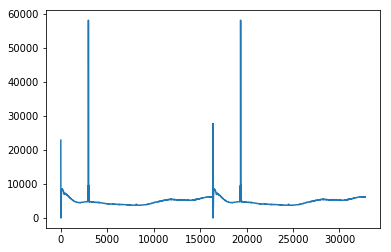

In [199]:
plt.plot(ondata[i])
#plt.plot(chdata[0])
#plt.xlim(8000, 8200)
#plt.ylim(-2,30)
plt.show()

## Baseline fitting

In [200]:
#baseline fitting parameter
center = 8000
width = 1000
start = 3000
end = 30000

#baseline fitting function
def f(x, a, b, c):
    return a*x**2 + b*x + c

def  baseline_fitting(arr_x, arr_y, index1, index2, index3, index4):
    tmpdata_y1 = arr_y[index1:index2]
    tmpdata_y2 = arr_y[index3:index4]
    tmpdata_x1 = arr_x[index1:index2]
    tmpdata_x2 = arr_x[index3:index4]
    x = numpy.concatenate([tmpdata_x1, tmpdata_x2])
    y = numpy.concatenate([tmpdata_y1, tmpdata_y2])
    param = numpy.polyfit(x, y, 2)
    arr_y = arr_y - f(arr_x, *param)
    return arr_y
    
#ch
xindex = numpy.linspace(0, vlen, vlen)

#baseline fitting index
index1 = int(start)
index2 = int(center - width/2)
index3 = int(center + width/2)
index4 = int(end)
print(index1, index2, index3, index4)

testoffset = numpy.linspace(1, vlen, vlen)

for i in tqdm(range(len(chdata))):
    chdata[i] = chdata[i] + testoffset#ベースラインフィッティングできているかの確認のため
    origin = chdata[i]#for debug, this will be deleted
    chdata[i] = baseline_fitting(xindex, chdata[i], index1, index2, index3, index4)
    
    
plt.plot(chdata[i], label="after chopper wheel")#after chopper wheel
plt.plot(origin, label="before chopper wheel")#before chopper wheel
plt.legend()
plt.grid()

100%|██████████| 5/5 [00:00<00:00, 349.52it/s]

3000 7500 8500 30000


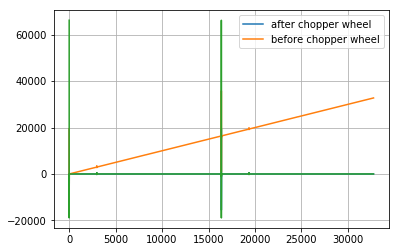

In [201]:
plt.plot(chdata[0])
plt.show()

In [202]:
#Vlsrの計算
vlsr = (new_xx - 16384)*dv

### astropyでfitsに書き出す

ヘッダーの作成

In [203]:
# header_dict = {
# "object": obs["object"],
# "crval1": obs["lambda_on"],
# "cdelt1": obs["grid"]/3600,
# "crpix1": obs["N"]-1/2,#中心ピクセル
# "crval2": obs["beta_on"],
# "cdelt2": obs["grid"]/3600,
# "crpix2": obs["N"]-1/2, #中心ピクセル
# "cdelt3": 0.16,# km/s 
# "crval3": 0
# }

# temp = """
# SIMPLE  =                    T                                                  
# BITPIX  =                  -32                                                  
# NAXIS   =                    3                                                  
# NAXIS1  =                  31                                                 
# NAXIS2  =                  31                                                 
# NAXIS3  =                   32768                                                  
# OBJECT  = '{object}              '                                                  
# TELESCOP= 'NANTEN2            '                                                  
# INSTRUME= 'MULT2-11          '                                                  
# OBSERVER= 'z7510rk           '                                                  
# DATE-OBS= '2007-12-30        '                                                  
# DATE-MAP= '2012-01-19        '                                                  
# BSCALE  =    0.10000000000E+01                                                  
# BZERO   =    0.00000000000E+01                                                  
# BUNIT   = 'K                 '                                                  
# EPOCH   =    0.20000000000E+04                                                  
# OBSRA   =    8.38104170000E+01                                                  
# OBSDEC  =   -5.37511100000E+00                                                  
# DATAMAX =    1.16774444580E+02                                                  
# DATAMIN =   -8.33924560547E+01                                                  
# CTYPE1  = 'RA---GLS          '                                                  
# CRVAL1  =    {crval1}                                                  
# CDELT1  =    {cdelt1}                                                  
# CRPIX1  =      {crpix1}
# CROTA1  =     0.0000000000E+00                                                  
# CTYPE2  = 'DEC--GLS          '                                                  
# CRVAL2  =   {crval2}                                                  
# CDELT2  =   {cdelt2}                                               
# CRPIX2  =     {crpix2}                                               
# CROTA2  =     0.0000000000E+00                                                  
# CTYPE3  = 'VELO-LSR          '                                                  
# CRVAL3  =    2.50000000000E+02                                                  
# CDELT3  =    5.00000000000E+02                                                  
# CRPIX3  =    1.00000000000E+00                                                  
# CROTA3  =    0.00000000000E+00                                                  
# BLANK   =   -1.00000000000E+00 """.format(**header_dict)

In [204]:
#target_header = fits.Header.fromstring(temp, sep = "\n")

In [205]:
#書き出し
#hdu = fits.PrimaryHDU([chdata, vlsr])
#hdulist = fits.HDUList([hdu])
#hdulist.writeto("ps.fits", overwrite = True)
hdu1 = fits.PrimaryHDU()
hdu2 = fits.ImageHDU([chdata, vlsr])
hdulist = fits.HDUList([hdu1, hdu2])
hdulist.writeto("ps.fits", overwrite = True)

KeyError: 'object'

In [206]:
##読み込み
hdu_list = fits.open("ps.fits")
hdu_r = hdu_list[1]
data = hdu_r.data
header = hdu_r.header

In [207]:
#解析にかかった時間を出すため
print("required time : {}".format(time.time() - start_time))

required time : 3905.153838157654


In [208]:
len(data[4])

32767

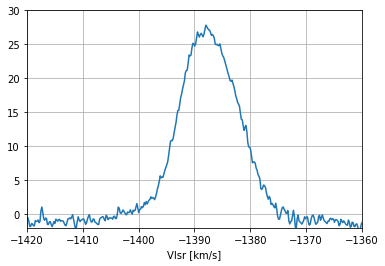

In [209]:
plt.plot(vlsr, chdata[0])
plt.grid()
plt.xlabel("Vlsr [km/s]")
plt.xlim(-1420, -1360)
plt.ylim(-2, 30)
plt.show()

In [210]:
plt.plot(hotdata[0], label="hot")
plt.plot(ondata[0], on="on")
plt.plot(offdata[0], off="off")
plt.plot(array_data[0], )
plt.show()

AttributeError: Unknown property on

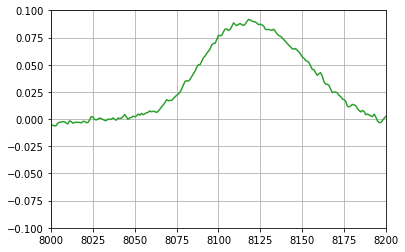

In [211]:
plt.plot((ondata[0]-offdata[0])/(hotdata[0]-offdata[0]))
plt.grid()
plt.xlim(8000, 8200)
plt.ylim(-0.1, 0.1)
plt.show()

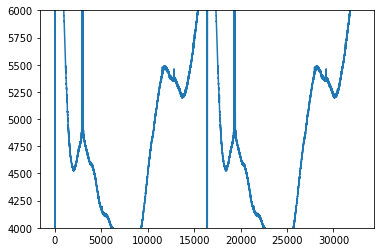

In [191]:
plt.plot(offdata[0])
plt.ylim(4000,6000)
plt.show()